# Note
* for the first part of the project: preprocessing the Covid dataset (from [this journal paper](https://www.nature.com/articles/s41746-020-00372-6) and the [GitHub](https://github.com/nshomron/covidpred/tree/master/data))
* At the end, the data is saved into a pickle file, which will used in the modeling work

# Load packages

In [1]:
import numpy as np
import pandas as pd

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.options.display.max_rows = 500 # display max rows
# pd.options.display.float_format = '{:.2f}'.format #supress scientific notation

# Display full output in Jupyter, not only last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 1.2.4
Numpy version: 1.20.1


# Raw data (df_raw)

## Load CSV data and save as pickle
* Read data from [this journal paper](https://www.nature.com/articles/s41746-020-00372-6) and the [GitHub](https://github.com/nshomron/covidpred/tree/master/data)
* This section only needs to be run for once
* part 1 was used in the published article
* all ~ 3 million observations will be used in this project, saved in `df_raw`

In [3]:
import zipfile

zf = zipfile.ZipFile('data/' + 'corona_tested_individuals_ver_006.english.csv.zip') 
df_part1 = pd.read_csv(zf.open('corona_tested_individuals_ver_006.english.csv'))

zf = zipfile.ZipFile('data/' + 'corona_tested_individuals_ver_0083.english.csv.zip') 
df_part2 = pd.read_csv(zf.open('corona_tested_individuals_ver_0083.english.csv'))

df = pd.concat([df_part1, df_part2])

print(df_part1.shape, df_part2.shape, df.shape)

# filter if needed
# df = df[df['test_date'].str.contains('2020-09', na=False)]

df_raw = df
df.shape
df.head()

(278848, 10) (2742596, 10) (3021444, 10)


(3021444, 10)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


# EDA
* Exploratory data analysis

## Quick check

In [4]:
df = df_raw

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021444 entries, 0 to 2742595
Data columns (total 10 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   test_date            object
 1   cough                object
 2   fever                object
 3   sore_throat          object
 4   shortness_of_breath  object
 5   head_ache            object
 6   corona_result        object
 7   age_60_and_above     object
 8   gender               object
 9   test_indication      object
dtypes: object(10)
memory usage: 253.6+ MB


In [5]:
df = df_raw

df.describe()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
count,3021444,3021444,3021444,3021444,3021444,3021444,3021444,2473800,2928558,3021444
unique,247,5,5,5,5,5,3,3,3,3
top,2020-09-17,0,0,0,0,0,negative,No,female,Other
freq,36557,2745977,2768502,2973176,2992658,2942734,2740630,2034256,1501602,2790300


## Target (y) distribution

* First, let us check the distribution of the target (`corona_result`)
* raw data: 91% negative, 8% positive, 1 other (this `other` class will be removed)
* the class is imbalanced

In [6]:
df = df_raw

df['corona_result'].value_counts()

df['corona_result'].value_counts(normalize=True)

negative    2740630
positive     235704
other         45110
Name: corona_result, dtype: int64

negative    0.907
positive    0.078
other       0.015
Name: corona_result, dtype: float64

## Feature (X) distribution (Data type)

Check value counts for all object-type columns
* Source: https://stackoverflow.com/questions/32589829/how-to-get-value-counts-for-multiple-columns-at-once-in-pandas-dataframe
* This code only works in the pandas > 1.1.0.
* A few issues are noted for the covid dataset: 'other' in the target of `corona_result`, 'None' in a few features
* All 'other'/'None'-containing rows will be removed 
* Note that some feature columns have 1/0 as both string and integer, we will change these into integers soon

In [7]:
df = df_raw

cols = [item for item in df.columns if 'test' not in item]
df = df[cols]

cat_cols = df.select_dtypes(include=object).columns.tolist()

(pd.DataFrame(
    df[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))

counts
column              value            
age_60_and_above    None       127320
                    Yes        312224
                    No        2034256
corona_result       other       45110
                    positive   235704
                    negative  2740630
cough               None          252
                    1           25875
                    0          121649
                    1          127691
                    0         2745977
fever               None          252
                    1           13582
                    1          105166
                    0          133942
                    0         2768502
gender              None        19563
                    male      1407393
                    female    1501602
head_ache           None            1
                    1             349
                    0           16354
                    1           62006
                    0         2942734
shortness_of_breath None            1
                    1             512
                    1           12082
                    0           16191
                    0         2992658
sore_throat         None            1
                    1             446
                    0           16257
                    1           31564
                    0         2973176

# Cleaning

For the covid dataset
* clean the data and save as `df_clean`
* **nulls**: drop all nulls (typical methods of dealing with NULL values: 1) drop, 2) as a separate arbitrary value, 3) impute as mean/median, 4) logical imputation of possible, 5) drop the column with excessive nulls)
* drop all rows containing the string of 'None'
* change the target of positive/negative to 1/0
* **categorical data**: 'test_indication', adjust to multiple columns (similar to dummify)

## data clean (df_clean)

In [8]:
df = df_raw.copy()

print('before cleaning:', df.shape)

# drop nan values
df = df.dropna()

# drop rows if any columns contain the string of 'None'
df=df.replace('None',np.nan).dropna(axis = 0, how = 'any')

# filter - exclude 'Other' as the test result
df = df[df['corona_result'].astype(str).str.contains('posit|nega', na = False)]

# adjust target values - 1 as positive
df['corona_result'] = df['corona_result'].apply(lambda x: 1 if x == 'positive' else 0)

# 1 as older than 60
df['age_60_and_above'] = df['age_60_and_above'].apply(lambda x: 1 if x == 'Yes' else 0)

# gender - male as 1
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'male' else 0)

# break 'test_indication' column into two binary classes
df['contact_with_confirmed'] = df['test_indication'].apply(lambda x: 1 if 'confirmed' in x else 0)
df['abroad'] = df['test_indication'].apply(lambda x: 1 if 'Abroad' in x else 0)

# adjust the date format
df['test_date'] = pd.to_datetime(df['test_date'])
df['test_year'] = pd.DatetimeIndex(df['test_date']).to_period('Y')
df['test_month'] = pd.DatetimeIndex(df['test_date']).to_period('M')
# df['only_year'] = pd.DatetimeIndex(df['test_date']).year
# df['only_month'] = pd.DatetimeIndex(df['test_date']).month

# adjust data format
cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df[cols] = df[cols].astype(int)

# show only essential columns
col_clean = [item for item in df.columns if ('_v0' not in item) and ('indication' not in item)]
df = df[col_clean]

df = df.reset_index(drop=True)

df_clean = df

print('after cleaning:', df.shape)

before cleaning: (3021444, 10)
after cleaning: (2288192, 13)


Take a look at data again, much cleaner

In [9]:
df = df_clean

df.head()

df.describe()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,contact_with_confirmed,abroad,test_year,test_month
0,2020-04-14,1,0,0,0,0,0,1,1,0,0,2020,2020-04
1,2020-04-14,1,0,0,0,0,1,0,0,0,0,2020,2020-04
2,2020-04-14,0,0,0,0,0,0,0,0,0,0,2020,2020-04
3,2020-04-14,0,1,0,0,0,0,0,0,0,1,2020,2020-04
4,2020-04-14,1,0,0,0,0,0,1,0,0,0,2020,2020-04


,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,contact_with_confirmed,abroad
count,2.288e+06,2.288e+06,2.288e+06,2.288e+06,2.288e+06,2.288e+06,2.288e+06,2.288e+06,2.288e+06,2.288e+06
mean,4.897e-02,4.029e-02,1.202e-02,4.412e-03,2.388e-02,9.586e-02,1.336e-01,4.871e-01,6.783e-02,1.327e-02
std,2.158e-01,1.966e-01,1.090e-01,6.628e-02,1.527e-01,2.944e-01,3.402e-01,4.998e-01,2.515e-01,1.144e-01
min,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
25%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
50%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
75%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,0.000e+00,0.000e+00
max,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00


## Column selection

In [10]:
col_X = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'contact_with_confirmed', 'age_60_and_above', 'gender', 'abroad']
col_y = ['corona_result']

# EDA - continued

## Feature vs target

## 1 - Pairplot

For covid data
* the pair-plot is not too useful for this dataset because more features are simply binary: 0 or 1

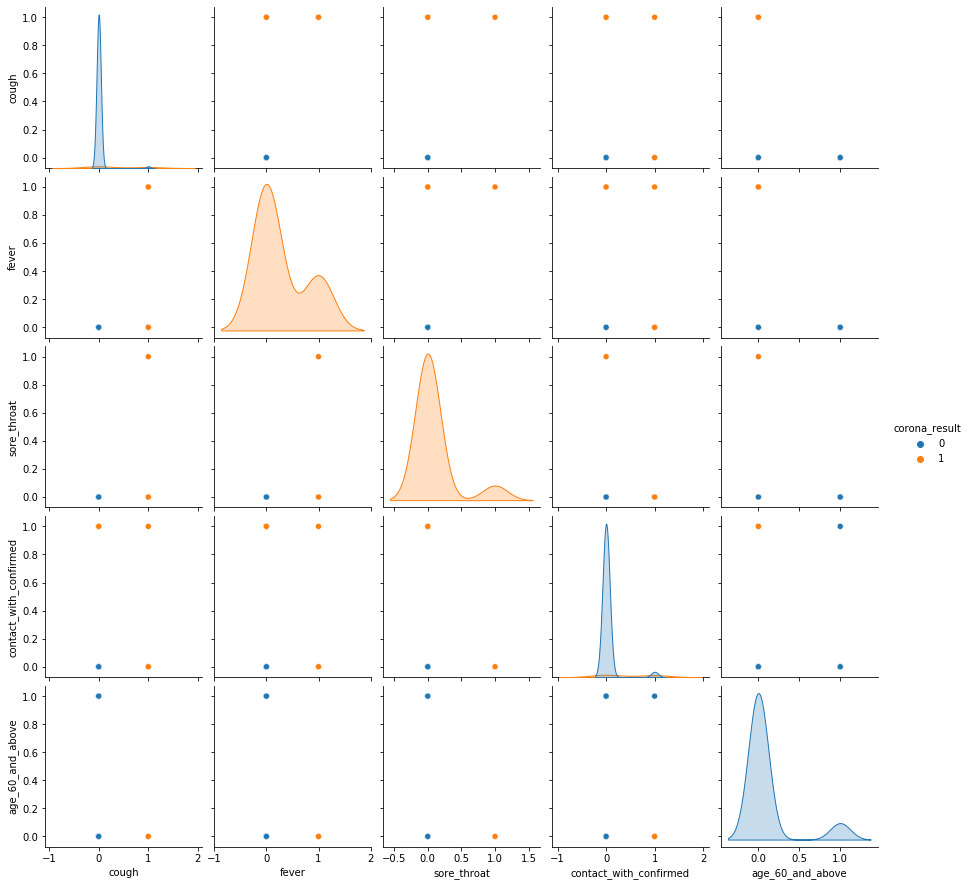

In [11]:
import seaborn as sns

df = df_clean
df = df.sample(100) # show only limited rows to save time

col = ['cough', 'fever', 'sore_throat', 'contact_with_confirmed', 'age_60_and_above'] + ['corona_result']
sns.pairplot(df[col], hue='corona_result');

## 2 - Correlation heat map

for the covid dataset
* from the correlation heat map, it looks that `contact_with_confirmed` has the highest correlation coefficient with the target of `corona_result` (0.49)
* this point will be validated in the feature importance analysis: `contact_with_confirmed` stands out as the critical feature

In [12]:
df = df_clean

col = col_X + col_y
df = df[col]

df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,cough,fever,sore_throat,shortness_of_breath,head_ache,contact_with_confirmed,age_60_and_above,gender,abroad,corona_result
cough,1.00,0.40,0.20,0.16,0.23,0.23,-0.00,0.01,0.37,0.24
fever,0.40,1.00,0.20,0.15,0.29,0.26,0.00,0.02,0.16,0.33
sore_throat,0.20,0.20,1.00,0.15,0.32,0.22,-0.02,-0.02,0.01,0.25
shortness_of_breath,0.16,0.15,0.15,1.00,0.16,0.11,0.01,-0.01,0.01,0.15
head_ache,0.23,0.29,0.32,0.16,1.00,0.31,-0.03,-0.01,-0.00,0.35
contact_with_confirmed,0.23,0.26,0.22,0.11,0.31,1.00,-0.03,0.00,-0.03,0.49
age_60_and_above,-0.00,0.00,-0.02,0.01,-0.03,-0.03,1.00,-0.01,-0.01,-0.01
gender,0.01,0.02,-0.02,-0.01,-0.01,0.00,-0.01,1.00,0.01,0.02
abroad,0.37,0.16,0.01,0.01,-0.00,-0.03,-0.01,0.01,1.00,0.00
corona_result,0.24,0.33,0.25,0.15,0.35,0.49,-0.01,0.02,0.00,1.00


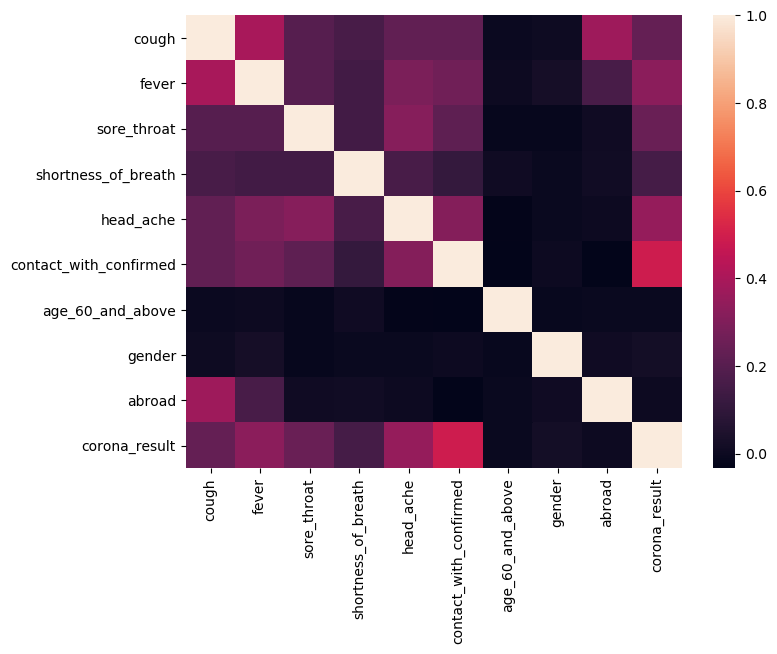

In [13]:
plt.figure(figsize=(8,6), dpi=100)
sns.heatmap(df.corr());

## 3 - Groupby by outcome
* groupby the outcome
* calculate the mean/distribution of the feature

for covid data
* this groupby by the outcome is particularly helpful in this study
* the global baseline of testing positive is 9.6%
* the effect of symptoms is clear: for example, for cases with `head_ache`, the probability of test positive is 80% (8 times higher than the baseline)
* the effect of symptoms and `contact_with_confirmed` is also obvious in the plot

In [14]:
# groupby, consider multiple features

df = df_clean.copy()

print('baseline:', round(np.mean(df['corona_result']), 3))

pd.options.display.float_format = '{:.2f}'.format #supress scientific notation

col_groupby = ['head_ache', 'contact_with_confirmed']
# col_groupby = ['cough', 'fever', 'sore_throat', 'shortness_of_breath']
col_agg = ['mean', 'std', 'count']
col_variable = ['corona_result']

df.groupby(col_groupby).agg(col_agg)[col_variable]

# df = df.groupby(col_groupby).agg(col_agg)[col_variable].reset_index()
# df.head(100)

baseline: 0.096


corona_result              
                                          mean  std    count
head_ache contact_with_confirmed                            
0         0                               0.05 0.22  2109493
          1                               0.60 0.49   124059
1         0                               0.80 0.40    23488
          1                               0.73 0.44    31152

In [15]:
# Predefine a few functions for plotting
# source: https://www.semicolonworld.com/question/43851/how-to-add-group-labels-for-bar-charts-in-matplotlib

from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos], transform=ax.transAxes, color='black', linewidth=0.5)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        
        angle = 90 if level == 10 else 0
        alpha = 0 if level == 10 else 1
        
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, rotation=angle, c= 'black', alpha = alpha)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

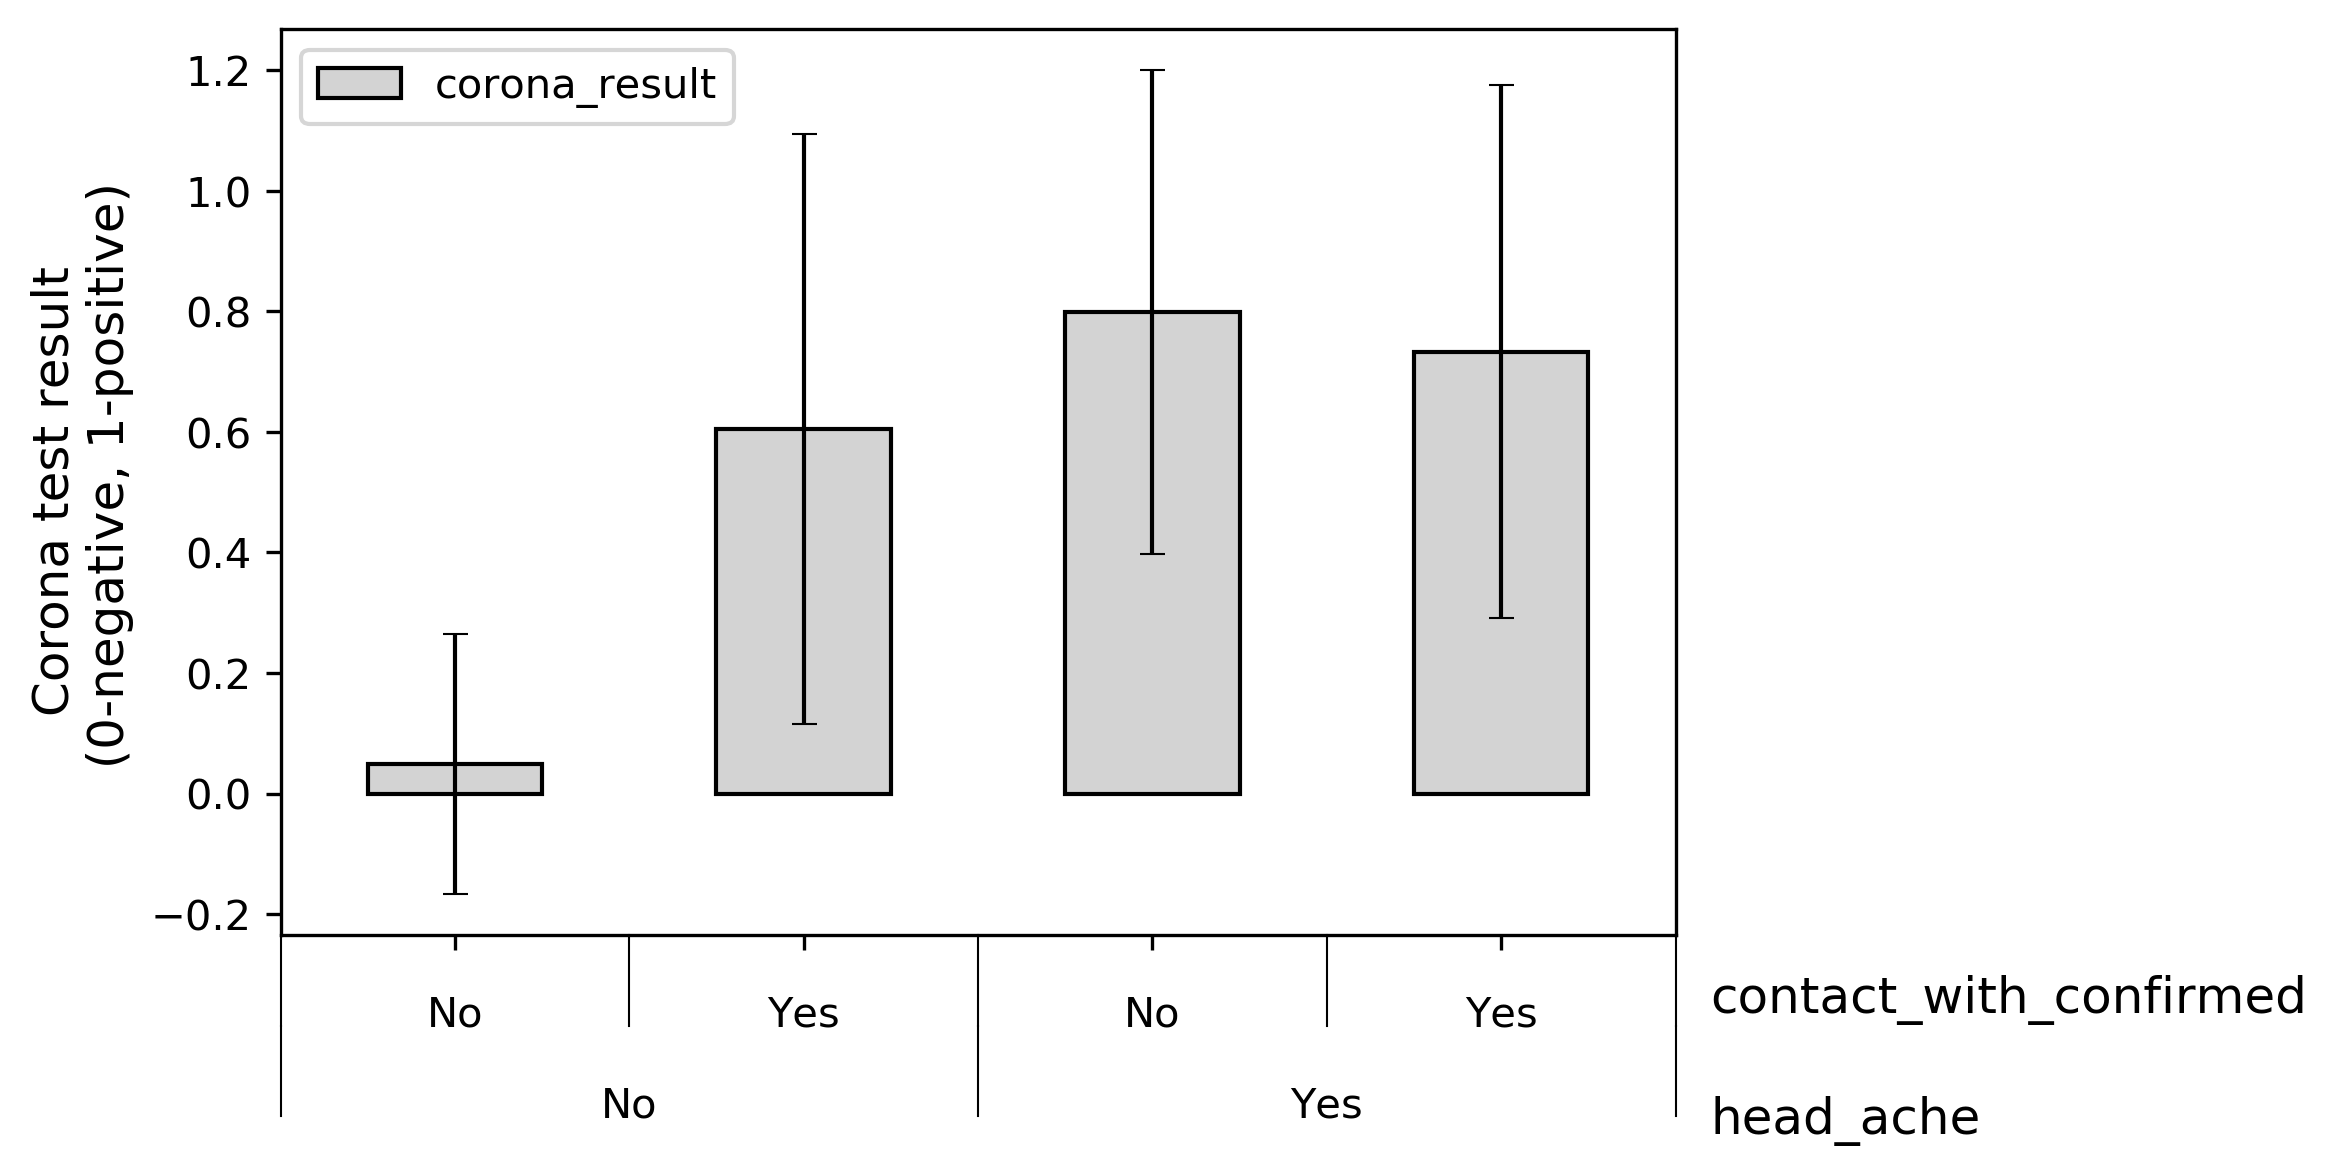

In [28]:
df = df_clean.copy()

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (6,4)

## groupby
col_groupby = ['head_ache', 'contact_with_confirmed']
# col_agg = ['mean']
col_variable, y_label = ['corona_result'], 'Corona test result \n (0-negative, 1-positive)'

df['head_ache'] = df['head_ache'].apply(lambda x: 'Yes' if x>0 else 'No')
df['contact_with_confirmed'] = df['contact_with_confirmed'].apply(lambda x: 'Yes' if x>0 else 'No')

df_ave = df.groupby(col_groupby)[col_variable].mean()
df_std = df.groupby(col_groupby)[col_variable].std()

# ax = df_ave.plot(kind='bar', stacked = True, color = 'tab:blue')
ax = df_ave.plot(kind='bar', stacked = False, yerr = df_std, error_kw=dict(capsize=3, lw=1, capthick=0.5), color = 'lightgrey', edgecolor = "black")

ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, df_ave)

ax.text(3.6, -0.3, col_groupby[1], fontsize=12, verticalalignment='top')
ax.text(3.6, -0.5, col_groupby[0], fontsize=12, verticalalignment='top')

plt.legend(loc='best')
# plt.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11, loc='upper left', borderaxespad=0.)
plt.ylabel(y_label, fontsize = 12)
# plt.ylim(0, 1.05)
plt.show();

* Here we are checking the probability of test result when each feature is 1
* The contribution of many symptoms are clear

In [17]:
# what is the contribution of each feature
# use a binary cut: > mean or < mean

df = df_clean.copy()

print('baseline:', round(np.mean(df['corona_result']), 3))

list_feature = []
list_mean = []
list_count = []
features = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'contact_with_confirmed', 'abroad']
for feature in features:
    
#     list_feature.append(feature + '=0')
#     list_mean.append(np.mean(df[(df[feature]<np.mean(df[feature]))]['corona_result']))
#     list_count.append(df[(df[feature]<np.mean(df[feature]))].shape[0])
    
    list_feature.append(feature + '=1; all rest features are 0')
    features_other = [item for item in features if (item != feature)]
    df['features_other'] = df[features_other].sum(axis=1)
    condition_1 = (df[feature]>0)
    condition_2 = (df['features_other']<1)
    list_mean.append(np.mean(df[(condition_1)&(condition_2)]['corona_result']))
    list_count.append(df[(condition_1)&(condition_2)].shape[0])
    

df = pd.DataFrame()
df['feature'] = list_feature
df['mean'] = list_mean
df['count'] = list_count
df = df.sort_values(by=['mean'], ascending = False)

df.head(10)

baseline: 0.096


,feature,mean,count
3,shortness_of_breath=1; all rest features are 0,0.84,296
4,head_ache=1; all rest features are 0,0.80,3122
2,sore_throat=1; all rest features are 0,0.76,1090
7,contact_with_confirmed=1; all rest features are 0,0.58,35779
1,fever=1; all rest features are 0,0.43,5910
0,cough=1; all rest features are 0,0.16,11246
8,abroad=1; all rest features are 0,0.11,2184
6,gender=1; all rest features are 0,0.04,846605
5,age_60_and_above=1; all rest features are 0,0.03,146377


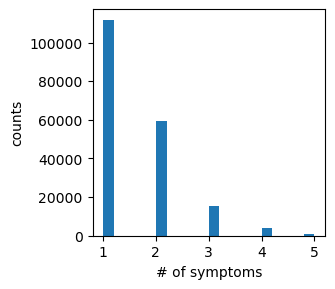

In [18]:
plt.figure(figsize=(3,3), dpi=100)

df = df_clean.copy()

# df[df['head_ache'] > 0].sample(5)
symptoms = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
df['symptoms'] = df[symptoms].sum(axis=1)
df = df[df['symptoms'] > 0]

plt.hist(df['symptoms'], bins=20)
plt.xlabel('# of symptoms')
plt.ylabel('counts')
plt.show();

groupby is used here

Asymptomatic
* Now we are looking into more details
* What is the positive-result probability for cases with no symptoms and no contact_with_confirmed? 3.69%
* Although 3.69% is low as compare with symptom--showing cases (~ 70%), it is quite critical, considering the large population (88% of all cases)

In [19]:
df = df_clean.copy()

print('baseline (all rows)')
print('probability:', round(np.mean(df['corona_result']), 3))

# df_asymptomatic = df[(df['cough']==0)&(df['fever']==0)&(df['sore_throat']==0)&(df['shortness_of_breath']==0)&(df['head_ache']==0)]
col_symptom = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
df['symptom_all'] = df[col_symptom].sum(axis=1)
df_asymptomatic = df[df['symptom_all'] < 1]

print('\nNo symptoms:')
print('case fraction:', round(df_asymptomatic.shape[0]/df.shape[0], 3))
print('positive probability:', round(np.mean(df_asymptomatic['corona_result']), 3))

print('\nNo symptoms & No contact_with_confirmed:')
print('case fraction:', round(df[(df['symptom_all']<1)&(df['contact_with_confirmed']==0)].shape[0]/df.shape[0], 3))
print('positive probability:', round(np.mean(df[(df['symptom_all']<1)&(df['contact_with_confirmed'] ==0)]['corona_result']), 3))

baseline (all rows)
probability: 0.096

No symptoms:
case fraction: 0.916
positive probability: 0.058

No symptoms & No contact_with_confirmed:
case fraction: 0.882
positive probability: 0.037


## play with Bayes here
* P(A|B) * P(B) = P (B|A) * P(A)
* A: no symptom
* B: test positive
* P(A|B) = P(no symptom/contact | test positive)
* P(B) = P(test positive)
* P(B|A) = P(test positive | no symptom/contact)
* P(A) = P(no symptom/contact)

In [20]:
df = df_clean.copy()

print('baseline (all rows)')
print('probability:', round(np.mean(df['corona_result']), 3))

# df_asymptomatic = df[(df['cough']==0)&(df['fever']==0)&(df['sore_throat']==0)&(df['shortness_of_breath']==0)&(df['head_ache']==0)]
col_symptom = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
df['symptom_all'] = df[col_symptom].sum(axis=1)

# define events
A = (df['symptom_all'] < 1) & (df['contact_with_confirmed']==0)
A_label = 'no symptom or contact'
B = (df['corona_result'] == 1)
B_label = 'test positive'

# P(A|B)
Probability_AGivenB = df[A&B].shape[0] / df[B].shape[0]

# P(B)
Probability_B = df[B].shape[0]/df.shape[0]

# P(B|A)
Probability_BGivenA = df[A&B].shape[0] / df[A].shape[0]

# P(A)
Probability_A = df[A].shape[0]/df.shape[0]

print('P(A|B) = P('+A_label+' | '+B_label+') =', round(Probability_AGivenB,3))
print('P(B) = P('+B_label+') =', round(Probability_B,3))
print('P(B|A) = P('+B_label+' | '+A_label+') =', round(Probability_BGivenA,3))
print('P(A) = P('+A_label+') =', round(Probability_A,3))

print('check:', round(Probability_AGivenB * Probability_B,3) == round(Probability_BGivenA * Probability_A, 3))

baseline (all rows)
probability: 0.096
P(A|B) = P(no symptom or contact | test positive) = 0.34
P(B) = P(test positive) = 0.096
P(B|A) = P(test positive | no symptom or contact) = 0.037
P(A) = P(no symptom or contact) = 0.882
check: True


# EDA - miscellaneous
* additional analysis during EDA

## groupby: cases over time

In [21]:
df = df_clean.copy()

rows = df.shape[0]
print('# of data points:', rows)

pd.options.display.float_format = '{:.2f}'.format #supress scientific notation

col_groupby = ['test_month']
col_agg = ['mean', 'count', 'nunique']
col_variable = ['corona_result']

df = df.groupby(col_groupby).agg(col_agg)[col_variable].reset_index()

df.head()

# of data points: 2288192


test_month corona_result                
                      mean   count nunique
0    2020-03          0.09  105690       2
1    2020-04          0.07  182104       2
2    2020-06          0.04  109622       2
3    2020-07          0.08  426104       2
4    2020-08          0.11  305121       2

## groupby: quantile

In [22]:
df = df_clean.copy()

rows = df.shape[0]
print('# of data points:', rows)

def q05(x): return x.quantile(0.05)
def q10(x): return x.quantile(0.10)
def q25(x): return x.quantile(0.25)
def q50(x): return x.quantile(0.50)
def q75(x): return x.quantile(0.75)
def q90(x): return x.quantile(0.90)
def q95(x): return x.quantile(0.95)

pd.options.display.float_format = '{:.2f}'.format #supress scientific notation

col_groupby = col_X
col_agg = ['count', 'mean', 'min', q05, q10, q25, q50, q75, q90, q95, 'max']
col_variable = col_y

df = df.groupby(col_groupby).agg(col_agg)[col_variable].reset_index()

df.columns = [' '.join(col).strip().replace(' ','_') for col in df.columns]

df = df.sort_values(by=[col_y[0]+'_'+'q10', col_y[0]+'_'+'q25'], ascending = False)

df = df[df['corona_result_count'] > 0.001*rows]

df.head(20)

# of data points: 2288192


,cough,fever,sore_throat,shortness_of_breath,head_ache,contact_with_confirmed,age_60_and_above,gender,abroad,corona_result_count,corona_result_mean,corona_result_min,corona_result_q05,corona_result_q10,corona_result_q25,corona_result_q50,corona_result_q75,corona_result_q90,corona_result_q95,corona_result_max
12,0,0,0,0,1,0,0,0,0,3122,0.80,0,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1
14,0,0,0,0,1,0,0,1,0,3209,0.77,0,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1
101,0,1,0,0,1,0,0,1,0,2361,0.79,0,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1
0,0,0,0,0,0,0,0,0,0,890380,0.03,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0,0,0,0,0,0,0,1,0,846605,0.04,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0,0,0,0,0,0,0,1,1,2489,0.16,0,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1
4,0,0,0,0,0,0,1,0,0,146377,0.03,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
6,0,0,0,0,0,0,1,1,0,128686,0.04,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
8,0,0,0,0,0,1,0,0,0,35779,0.58,0,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1
9,0,0,0,0,0,1,0,1,0,36934,0.57,0,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1


## barplot

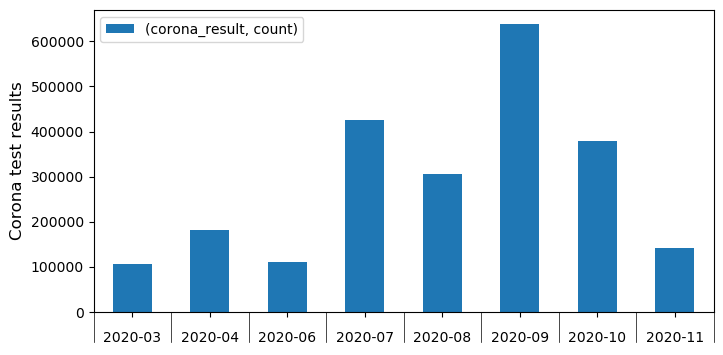

In [23]:
# # of covid tests over time

df = df_clean.copy()

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (8,4)

## - - - - - - Set-up for groupby - - - - - -
col_groupby = ['test_month'] 
# col_agg = ['mean'] # ['mean', 'std', 'count']
col_agg = ['count'] 
col_variable, y_label = ['corona_result'], 'Corona test results'

df[col_variable] = df[col_variable].astype(float)

# ## - - - - - - change labal names - - - - - - 
# col = [item.split('_')[0] for item in col_variable]
# df[col] = df[col_variable]
# col_variable = col

df_ave = df.groupby(col_groupby).agg(col_agg)[col_variable]
df_std = df.groupby(col_groupby)[col_variable].std()

ax = df_ave.plot(kind='bar', stacked = True, color = 'tab:blue')
# ax = df_ave.plot(kind='bar', stacked = False, yerr = df_std, error_kw=dict(capsize=3, lw=1, capthick=0.5), edgecolor = "black")

ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, df_ave)

plt.legend(loc='best')
# plt.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11, loc='upper left', borderaxespad=0.)
plt.ylabel(y_label, fontsize = 12)
# plt.ylim(0, 1.05)
plt.show();

## barplot - stacked

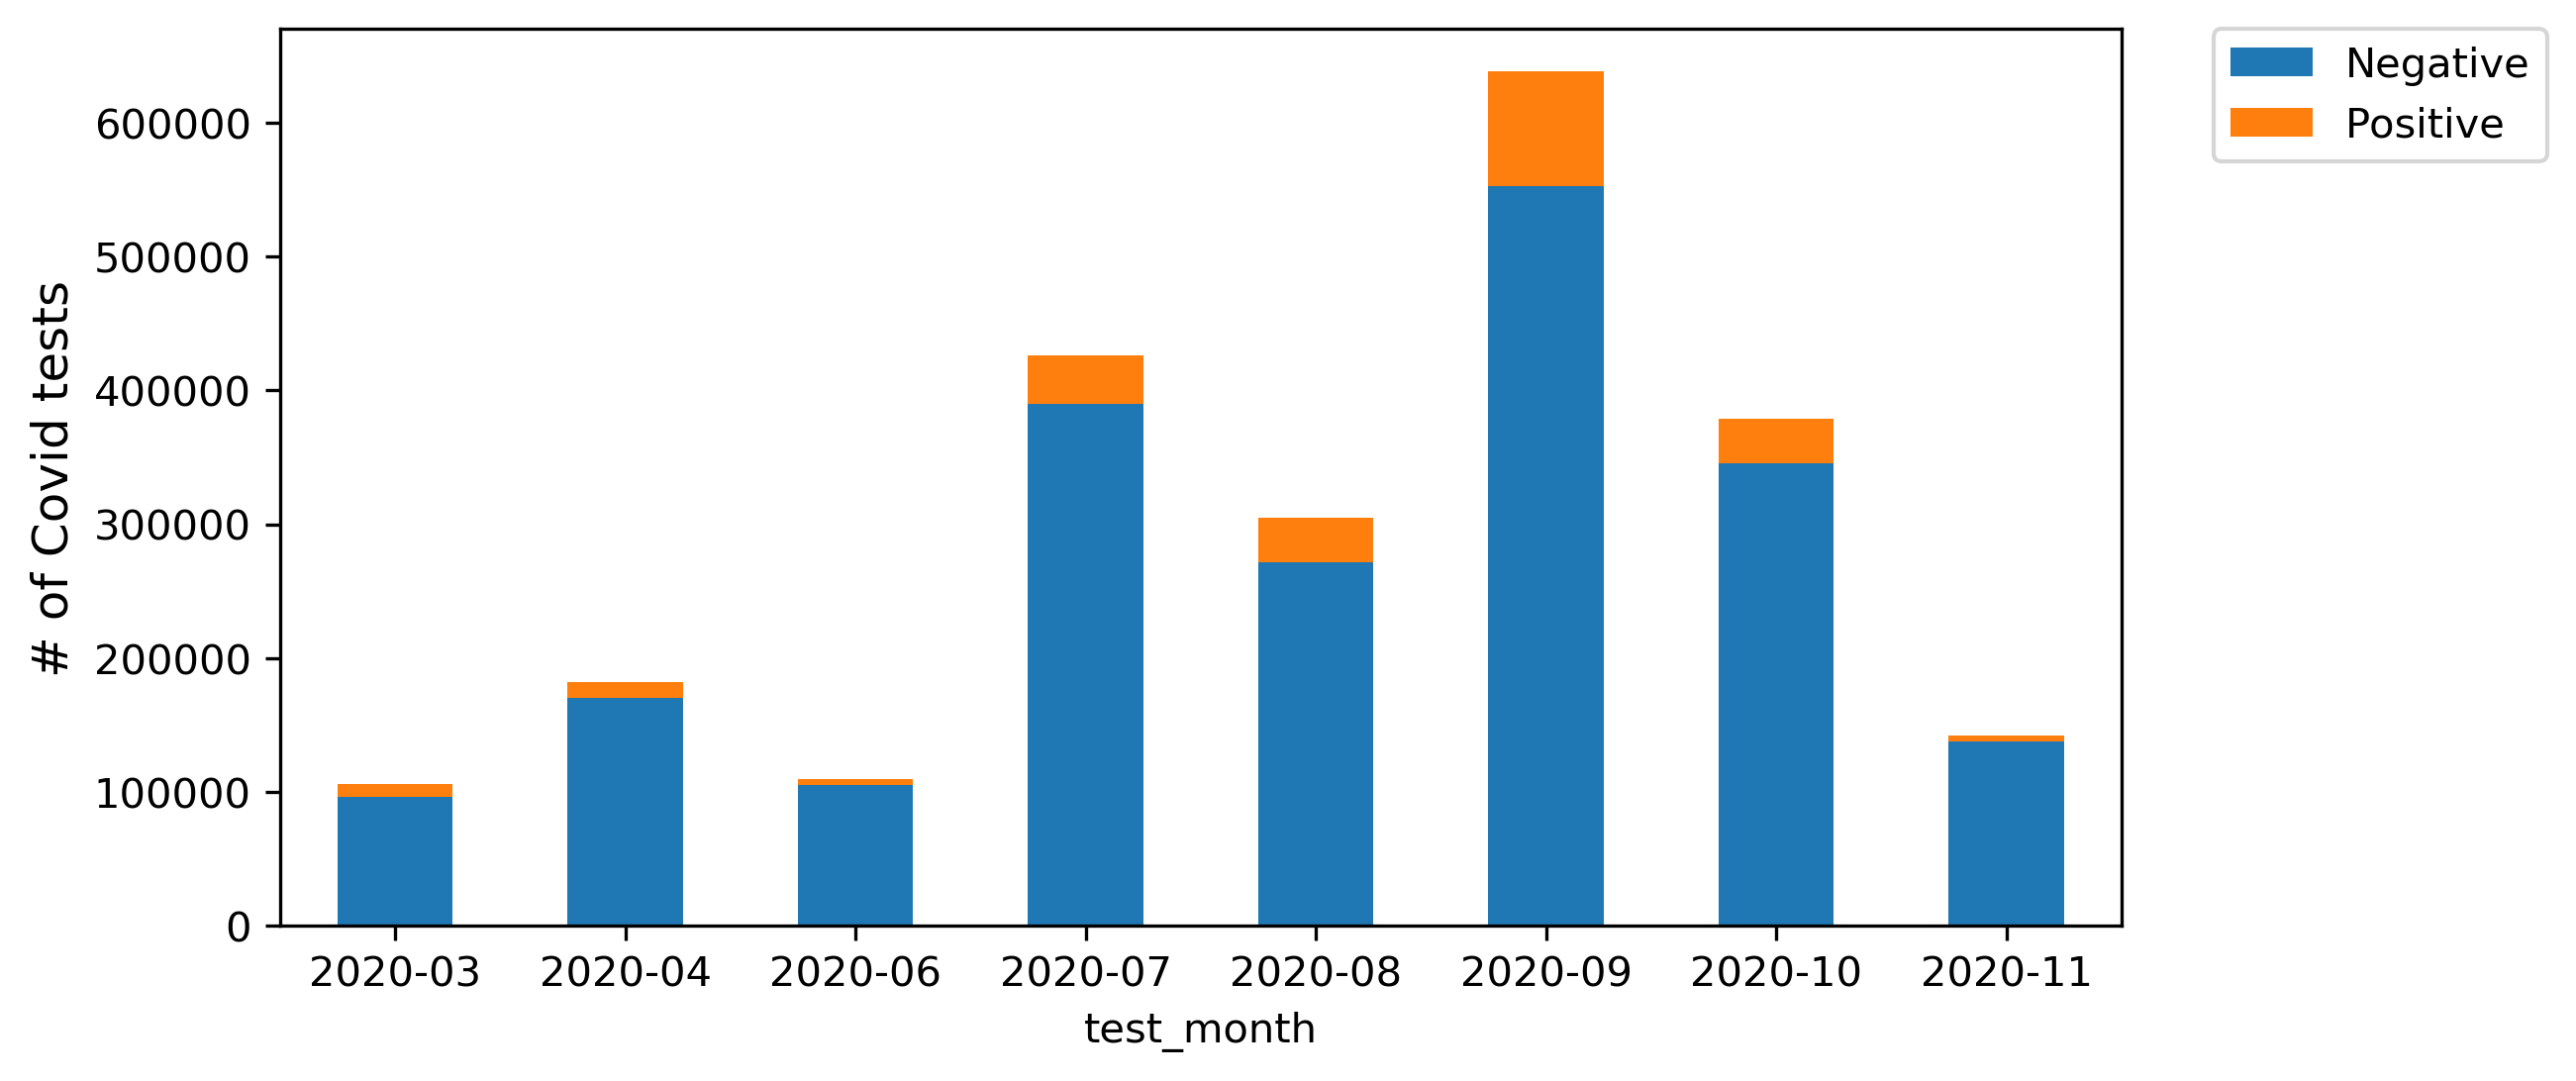

In [24]:
df = df_clean.copy()

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (8, 4)

## - - - plot 1: stacked by test results - - -
col_y = 'corona_result'
df[col_y]=df[col_y].replace(1, 'Positive').dropna(axis = 0, how = 'any')
df[col_y]=df[col_y].replace(0, 'Negative').dropna(axis = 0, how = 'any')
df = df.groupby(['test_month', col_y]).size().to_frame('Count')
df = df.reset_index()
table = pd.pivot_table(df, values='Count', index=['test_month'], columns=[col_y], aggfunc=np.sum)

## - - - plot 2: stacked by feature - - -
# col_y = 'age_60_and_above'
# df[col_y]=df[col_y].replace(1, 'over 60').dropna(axis = 0, how = 'any')
# df[col_y]=df[col_y].replace(0, 'under 60').dropna(axis = 0, how = 'any')
# df = df.groupby(['test_month', col_y]).size().to_frame('Count')
# df = df.reset_index()
# table = pd.pivot_table(df, values='Count', index=['test_month'], columns=[col_y], aggfunc=np.sum)

## - - - plot 3: stacked by engineered feature - - -
# col_symptom = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
# df['symptom'] = df[col_symptom].sum(axis=1)
# df['symptom'] = df['symptom'].apply(lambda x: 1 if x >0 else 0)
# col_y = 'symptom'
# df[col_y]=df[col_y].replace(1, 'Show symptoms').dropna(axis = 0, how = 'any')
# df[col_y]=df[col_y].replace(0, 'No symptoms').dropna(axis = 0, how = 'any')
# df = df.groupby(['test_month', col_y]).size().to_frame('Count')
# df = df.reset_index()
# table = pd.pivot_table(df, values='Count', index=['test_month'], columns=[col_y], aggfunc=np.sum)


colors = list(plt.cm.tab10(np.arange(10))) + ["limegreen", 'royalblue', 'lightcoral', 'b', 'cyan', 'violet']
table.plot(kind="bar", stacked=True, color = colors)

plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize = 10, loc='upper left', borderaxespad=0.)
plt.xticks(rotation = 0)
# plt.xlabel('Month in 2020', fontsize = 12)
plt.ylabel('# of Covid tests', fontsize = 12)
plt.show();

## boxplot
* boxplot is super useful for visualizing the distribution
* however, for the extremely imbalanced dataset, the horizontal lines of 25%, 50%, 75% quantile are overlapping

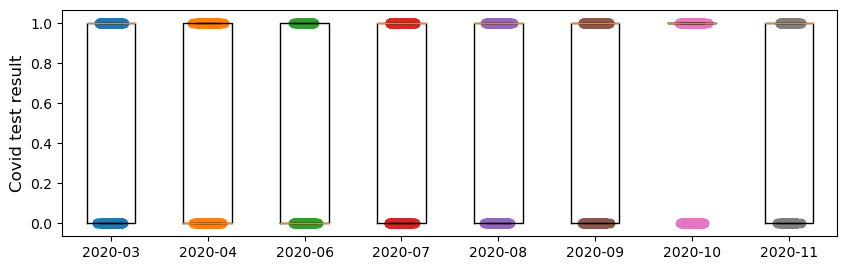

In [25]:
df = df_clean.copy()

# filter
# df = df.sample(1000)
df = df[df['contact_with_confirmed'].astype(str).str.contains('1', na = False)]
df = df[df['cough'].astype(str).str.contains('1', na = False)]

## - - - Set-up for groupby - - -
col_groupby = ['test_month']
col_variable, y_label = 'corona_result', 'Covid test result'

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10,3)

## - - - get data - - -
names, vals, xs = [], [] ,[]
for index, (name, subdf) in enumerate(df.groupby(col_groupby)):
    names.append(name)
    vals.append(list(subdf[col_variable]))
    xs.append(np.random.normal(index+1, 0.04, subdf.shape[0]))
    
## - - - boxplot - - -
plt.boxplot(vals, labels = names, showfliers=False)
# sns.boxplot(x = df['test_month'], y =df["corona_result"])

## - - - scatter-plot - - -
ngroup = len(vals)
clevels = np.linspace(0., 1., ngroup)
for x, val, clevel in zip(xs, vals, clevels):
    plt.scatter(x, val, alpha=1)

# ## - - - grouped axis with separation lines - - -
# df_ave = df.groupby(col_groupby)[col_variable].mean()
# ax = df_ave.plot(alpha = 0)
# ax.set_xticklabels('')
# ax.set_xlabel('')
# label_group_bar_table(ax, df_ave)
    
## - - - plot format - - -
plt.ylabel(y_label, fontsize = 12)
# plt.ylim([0.0, 0.2])
plt.show();

# Save data for modeling

## Save data (`df_covid`)

In [26]:
df = df_clean.copy()

col_model = [item for item in df.columns if ('test_' not in item) and ('only' not in item)]
df = df[col_model]

col_X = [item for item in df.columns if 'corona_result' not in item]
col_y = ['corona_result']

df = df[col_X + col_y]

df = df.reset_index(drop=True)

df.head()

df_covid= df

df.sample(100000).to_pickle('data/' + 'df_covid_100000rows.pkl')
# df.sample(100000).to_pickle('data/' + 'df_covid_100000rows_2020.09.pkl') # 

# df.describe()
df['corona_result'].value_counts()
df.shape

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad,corona_result
0,1,0,0,0,0,1,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0


0    2068840
1     219352
Name: corona_result, dtype: int64

(2288192, 10)